In [1]:
import os
import sys
sys.path.append('/Users/wangqiqian/Desktop/TrafficTDApython/')

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

# os.chdir(current_dir_path + '\\ultils')
os.chdir(current_dir_path + '/ultils')
print(current_dir_path)

import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering

from functions import *
from chi import *
from regressionP import *
from models import *
from utils_v3 import *

os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')
# os.chdir('C:/Users/USER/Desktop/TrafficTDApython/')

/Users/wangqiqian/Desktop/TrafficTDApython


In [2]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]
data7 = pd.read_csv("Data/NPA_TMA2_7.csv", low_memory=False)[:-2]
data8 = pd.read_csv("Data/NPA_TMA2_8.csv", low_memory=False)[:-2]
data9 = pd.read_csv("Data/NPA_TMA2_9.csv", low_memory=False)[:-2]
data10 = pd.read_csv("Data/NPA_TMA2_10.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)
# dataA2 = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [9]:
data9.shape

(72591, 51)

In [15]:
select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',
    
    # 同時保留大小類別可能是冗長的
    # 小類別
    # '道路型態子類別名稱', '事故位置子類別名稱',
    # '車道劃分設施-分向設施子類別名稱', 
    # '事故類型及型態子類別名稱', '肇因研判子類別名稱-主要', '當事者區分-類別-子類別名稱-車種', '當事者行動狀態子類別名稱',
    # '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位子類別名稱-其他', '肇因研判子類別名稱-個別', 
    
    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '肇因研判大類別名稱-主要', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別',
]

def preprocess(input_data, select_lst):
    # 篩選到第一個順位，因為注重的是單次事故的情況
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 11]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    # 補齊缺失值
    dist_df[select_lst] = dist_df[select_lst].fillna('未紀錄')

    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

# 每個月各取2萬筆
# dist_dfA2 = dist_dfA2.groupby('發生月份').apply(lambda x: x.sample(n=min(len(x), 20000), random_state=42)).reset_index(drop=True)

# # Concat
# rbind_data = pd.concat([dist_dfA1, dist_dfA2], axis=0, ignore_index=True)
# rbind_data.drop(columns=['發生月份'], inplace=True)

In [17]:
print(dist_dfA1.shape)
print(dist_dfA2.shape)

(1383, 33)
(317023, 33)


In [23]:
from sklearn.utils import resample

sampling_ratio = 0.5

# 計算 A1 和 A2 原始數據量比例
A1_total = len(dist_dfA1)
A2_total = len(dist_dfA2)
total_ratio = A1_total / A2_total  # 保留 A1/A2 的比例

# 定義函數，按月份進行下採樣
def downsample_by_month_simple(A1, A2, sampling_ratio, total_ratio):
    A1_downsampled = pd.DataFrame()
    A2_downsampled = pd.DataFrame()

    months = sorted(set(A1['發生月份']).intersection(A2['發生月份']))  # 確保月份匹配

    for month in months:
        # 提取該月份的資料
        A1_month = A1[A1['發生月份'] == month]
        A2_month = A2[A2['發生月份'] == month]

        # 計算該月份目標數量
        A1_target = int(len(A1_month) * sampling_ratio)
        A2_target = int(A1_target / total_ratio)
        print(A1_target)
        print(A2_target)

        # 下採樣
        A1_sampled = resample(A1_month, replace=False, n_samples=A1_target, random_state=42)
        A2_sampled = resample(A2_month, replace=False, n_samples=A2_target, random_state=42)

        # 合併到最終結果
        A1_downsampled = pd.concat([A1_downsampled, A1_sampled])
        A2_downsampled = pd.concat([A2_downsampled, A2_sampled])

    return A1_downsampled.reset_index(drop=True), A2_downsampled.reset_index(drop=True)

# 下採樣
downsampled_A1, downsampled_A2 = downsample_by_month_simple(dist_dfA1, dist_dfA2, sampling_ratio, total_ratio)

# 檢查結果
print(f"下採樣前 A1 資料量：{len(dist_dfA1)} / 下採樣後 A1 資料量：{len(downsampled_A1)}")
print(f"下採樣前 A1 資料量：{len(dist_dfA2)} / 下採樣後 A2 資料量： {len(downsampled_A2)}")
print("舊 A1/A2 比例：", len(dist_dfA1) / len(dist_dfA2))
print("新 A1/A2 比例：", len(downsampled_A1) / len(downsampled_A2))

# Concat
rbind_data = pd.concat([downsampled_A1, downsampled_A2], axis=0, ignore_index=True)
rbind_data.drop(columns=['發生月份'], inplace=True)

74
16962
79
18109
67
15358
56
12836
60
13753
64
14670
75
17192
71
16275
65
14899
78
17879
下採樣前 A1 資料量：1383 / 下採樣後 A1 資料量：689
下採樣前 A1 資料量：317023 / 下採樣後 A2 資料量： 157933
舊 A1/A2 比例： 0.004362459506092618
新 A1/A2 比例： 0.004362609460973958


In [24]:
bins_age = [0, 14, 24, 34, 44, 54, 64, 74, float('inf')]
labels_age = ['未滿15歲', '15~24', '25~34', '35~44', '45~54', '55~64', '65~74', '75+']

rbind_data['當事者事故發生時年齡'] = pd.cut(rbind_data['當事者事故發生時年齡'], bins=bins_age, labels=labels_age, right=False)

rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].cat.add_categories('未知')
rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].fillna('未知')

bins_speed = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, float('inf')]
labels_speed = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '110+']

rbind_data['速限-第1當事者'] = pd.cut(rbind_data['速限-第1當事者'], bins=bins_speed, labels=labels_speed, right=False)

# assert rbind_data.shape[0] == dist_dfA1.shape[0] + dist_dfA2.shape[0]
# Dummy
rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print('dummy_data:', dummy_data.shape)

data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
mapper_numpy = data_to_map.to_numpy()

dummy_data: (158622, 174)


### Multiple correspondence analysis (MCA)
多重對應分析是專門針對dummy來進行降維的，所以使用它作為主要方法沒有問題

In [29]:
import prince

mca = prince.MCA(
    one_hot=False,
    n_components=6,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42
)

mca.fit(data_to_map)
lens = mca.transform(data_to_map)

print(mca.eigenvalues_summary)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.266         5.61%                      5.61%
1              0.196         4.13%                      9.74%
2              0.117         2.48%                     12.22%
3              0.110         2.32%                     14.54%
4              0.098         2.07%                     16.61%
5              0.083         1.75%                     18.36%


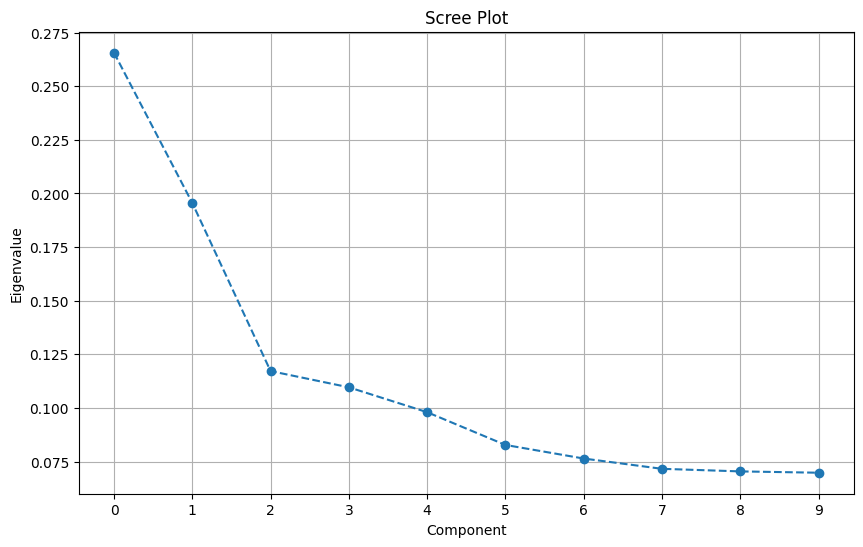

In [28]:
eigenvalues = mca.eigenvalues_

components = range(0, len(eigenvalues))

variance = mca.eigenvalues_summary['% of variance']

plt.figure(figsize=(10, 6))
plt.plot(components, eigenvalues, marker='o', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.xticks(components)
plt.grid(True)
plt.show()

In [30]:
eigenvalues = mca.eigenvalues_summary
eigenvalues['eigenvalue'] = eigenvalues['eigenvalue'].astype(float)
eigenvalues['eigenvalue'].sum()/mca.total_inertia_

0.18380281690140848

1. lens：以component為8對所有資料做MCA

In [9]:
# lens.to_csv('./Version3/Calculated/lens.csv', index=False)

# lens = pd.read_csv("./Version3/Calculated/lens.csv")
# lens

# Find the best mapper

In [31]:
from Version3.tdamapper.core import MapperAlgorithm
from Version3.tdamapper.cover import CubicalCover
from Version3.tdamapper.clustering import FailSafeClustering
from Version3.tdamapper.plot import MapperLayoutInteractive

In [9]:
os.cpu_count()

12

In [32]:
import pickle

detailed_results = []

for overlap in range(3, 6):
    silhouette_for_intervals = []

    for interval in range(5, 11):
        try:
            print(f'overlap: {overlap}, interval: {interval}')

            mapper_algo = MapperAlgorithm(
                cover=CubicalCover(
                    n_intervals=interval,
                    overlap_frac=overlap / 10
                ),
                clustering=FailSafeClustering(
                    AgglomerativeClustering(
                        n_clusters=2,
                        linkage='ward'
                    )
                ),
                n_jobs=6
            )

            mapper_info = mapper_algo.fit_transform(mapper_numpy, lens)
            silhouette_for_intervals.append(mapper_info[1])

            result = {
                "overlap": overlap,
                "interval": interval,
                "silhouette": mapper_info[1],
                "mapper_info": mapper_info
            }

            detailed_results.append(result)

            filename = f"/Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component6FullData/results_o{overlap}i{interval}.pkl"

            with open(filename, 'wb') as file:
                pickle.dump(result, file)

            print(f"Results saved to {filename}")

        except Exception as e:
            print(f"Error for overlap={overlap}, interval={interval}: {e}")

            continue

overlap: 3, interval: 5


Processing Clusters:  12%|█▏        | 19/153 [21:41<3:17:13, 88.31s/it]

### 未增加天氣
1. full_grid：使用Interval優化的前兩個月grid search
2. full_grid_sample：抽樣30%資料且沒有使用Interval優化
3. full_grid_sample_r2：和第二點一樣但是第二回合
4. full_grid_fulldata_o5i6：整筆資料的拓樸使用覆蓋為5區間數為6
5. full_grid_fulldata_o345i10：區間數固定為10的情況下覆蓋為345的資料

In [ ]:
# detailed_results_df = pd.DataFrame(detailed_results)
# detailed_results_df.to_csv("/Users/wangqiqian/Desktop/TrafficTDApython/Version3/GridSearch/full_grid_fulldata_o345i10.csv", index=False)

# output_file = '/Users/wangqiqian/Desktop/TrafficTDApython/Version3/GridSearch/full_grid_fulldata_o345i10.pkl'
# with open(output_file, 'wb') as f:
#     pickle.dump(detailed_results_df, f)

# print(f"Results saved to {output_file}")